In [ ]:
# You only need to run this once per machine
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 10.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 13.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from huggingface_hub import login
login()


Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from datasets import load_dataset
train_dataset = load_dataset('json', data_files = "data/AIPI-Incoming-Student-FAQ.json",split='train[:80%]')
eval_dataset = load_dataset('json', data_files = "data/AIPI-Incoming-Student-FAQ.json",split='train[80%:]')

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['answer', 'question'],
    num_rows: 74
})

In [ ]:
eval_dataset

Dataset({
    features: ['answer', 'question'],
    num_rows: 19
})

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [ ]:
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "journal-finetune-2"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
def formatting_func(example):
    text = f"### Instruction:\nUse the provided question to create an instruction that could have been used to generate the answer with an LLM.### Question: {example['question']}\n ### <ans> Answer: {example['answer']}</ans>"
    return text

In [ ]:
formatting_func(eval_dataset[15])

"### Instruction:\nUse the provided question to create an instruction that could have been used to generate the answer with an LLM.### Question: HOW DO I GET INVOLVED IN ATHLETICS AT DUKE?\n ### <ans> Answer: Our 27 Division 1 teams generate incredible school spirit. Students can attend all sporting events for free. If you have questions about the recruitment process for Division 1 teams, please visit GODUKE.COM. SPORT CLUBS provide the opportunity to participate in organized sport and competitive activities. Each Sport Club is composed of individuals who share a common interest in recreation sport and organize to collectively pursue their goals to either compete locally or at the national level. While previous experience in the sport you choose is helpful, it is not required. Our Sport Clubs are inclusive, which means there are no tryouts or cuts made. Whether you're a competitive sports enthusiast or looking for a source of exercise, Duke's INTRAMURAL SPORTS PROGRAM provides a wide v

Here's another common one:

```python
def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    return text
```

 ### 1. Load Base Model

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "drive/MyDrive/Colab Notebooks/Mixtral-7B-finetune/"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

### 2. Integrate QA dataset

In [ ]:
eval_dataset[0]

{'question': 'How do registration windows work?',
 'answer': 'The registration process works like this: Seniors register for classes on one day. Juniors register next, with two registration days/ windows. Sophomores register after that, also with two registration windows. First-year students register last, in two registration windows, in the summer. You will be assigned to one of two registration days for your class. Assignment is based on the last two digits of your Student ID number which is displayed in DukeHub. Your registration window will change each semester, if you are in the second window for fall registration, you will move to the first window for spring classes.'}

Reformat the prompt and tokenize each sample:

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

In [ ]:
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

93


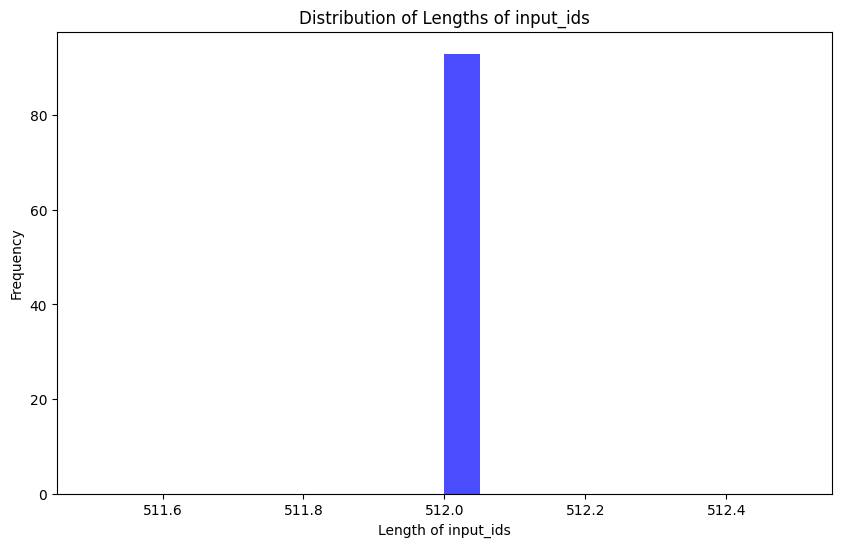

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### 3.Tokenize

In [ ]:
max_length = 512 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Check that `input_ids` is padded on the left with the `eos_token` (2) and there is an `eos_token` 2 added to the end, and the prompt starts with a `bos_token` (1).

In [ ]:
print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

Now all the samples should be the same length, `max_length`.

93


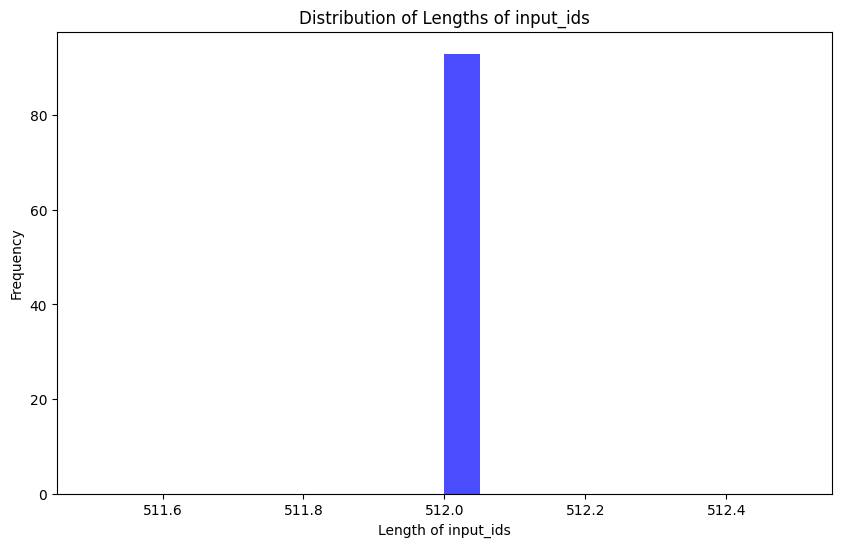

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
eval_prompt = """ Answer the following question:

### What is the word that describes all the devices that express time?

### Chronometer.\n\nA chronometer is an extraordinarily accurate timepiece, with an original focus on the needs of maritime navigation. The modern chronometer is, broadly speaking, an instrument for measuring time, especially one designed to measure time very accurately in spite of motion or variations in temperature, humidity, and air pressure. This is the largest category that encompasses every possible device whose function is to measure the passing of time.
"""

In [ ]:
eval_dataset[0]['conversations']

['What is the word that describes all the devices that express time?',
 'Chronometer.\n\nA chronometer is an extraordinarily accurate timepiece, with an original focus on the needs of maritime navigation. The modern chronometer is, broadly speaking, an instrument for measuring time, especially one designed to measure time very accurately in spite of motion or variations in temperature, humidity, and air pressure. This is the largest category that encompasses every possible device whose function is to measure the passing of time. ']

The `eval_prompt` I used was:

In [ ]:
eval_prompt = """Answer the following question:

### Question: What is the word that describes all the devices that express time?

### Answer:
"""

In [ ]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Answer the following question:

### Question: What is the word that describes all the devices that express time?

### Answer:

The word you are looking for is "chronometer". A chronometer is a device used to measure time. It can be an analog clock, digital watch or even a stopwatch. The term was first coined in 1735 by John Harrison when he invented his marine chronometers which were used on ships at sea to determine longitude accurately. Today we use many different types of clocks and watches but they all serve one purpose - telling us what time it is!

## Chronograph

A chronograph is a type of watch that has two hands, one for hours and minutes and another for seconds. The second hand moves around the dial every minute while the hour hand moves once per hour. This allows you to see how much time has passed since your last measurement (or start point). For example if you set your timer at noon then after 20 minutes have passed you would see 12:40 on your watch face indicating that 20

Observe how the model does out of the box.

### 4. Set Up LoRA

In [ ]:
from peft import PeftModel

In [ ]:

first_tuned_model = model

In [ ]:
from peft import prepare_model_for_kbit_training

first_tuned_model.gradient_checkpointing_enable()
first_tuned_model = prepare_model_for_kbit_training(first_tuned_model)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
print(first_tuned_model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=4096, out_features=32, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=32, out_features=4096, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (k_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=4096, out_features=1024, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inpl

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

first_tuned_model = get_peft_model(first_tuned_model, config)
print_trainable_parameters(first_tuned_model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


See how the model looks different now, with the LoRA adapters added:

In [ ]:
print(first_tuned_model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer):

### 5. Run Training!

I didn't have a lot of training samples: only about 200 total train/validation. I used 500 training steps, and I was fine with overfitting in this case. I found that the end product worked well. It took about 20 minutes on the 1x A10G 24GB.

Overfitting is when the validation loss goes up (bad) while the training loss goes down significantly, meaning the model is learning the training set really well, but is unable to generalize to new datapoints. In most cases, this is not desired, but since I am just playing around with a model to generate outputs like my journal entries, I was fine with a moderate amount of overfitting.

With that said, a note on training: you can set the `max_steps` to be high initially, and examine at what step your model's performance starts to degrade. There is where you'll find a sweet spot for how many steps to perform. For example, say you start with 1000 steps, and find that at around 500 steps the model starts overfitting, as described above. Therefore, 500 steps would be your sweet spot, so you would use the `checkpoint-500` model repo in your output dir (`mistral-journal-finetune`) as your final model in step 6 below.

If you're just doing something for fun like I did and are OK with overfitting,

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    first_tuned_model.is_parallelizable = True
    first_tuned_model.model_parallel = True

In [ ]:
first_tuned_model = accelerator.prepare_model(first_tuned_model)

In [ ]:
import transformers
from datetime import datetime

project = "journal-finetune-aipi"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=first_tuned_model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        fp16=True,
        optim="paged_adamw_8bit",
        logging_steps=10,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

first_tuned_model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,1.354100,1.479971
50,0.864400,1.480367
75,0.844900,1.542553
100,0.550100,1.673273
125,0.269100,1.807681
150,0.218700,1.960304
175,0.140800,2.013195
200,0.089200,2.204844
225,0.089100,2.248723
250,0.063300,2.230318


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:158: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:158: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

Step,Training Loss,Validation Loss
25,1.354100,1.479971
50,0.864400,1.480367
75,0.844900,1.542553
100,0.550100,1.673273
125,0.269100,1.807681
150,0.218700,1.960304
175,0.140800,2.013195
200,0.089200,2.204844
225,0.089100,2.248723
250,0.063300,2.230318


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:158: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:158: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

TrainOutput(global_step=500, training_loss=0.2661017942428589, metrics={'train_runtime': 830.235, 'train_samples_per_second': 1.204, 'train_steps_per_second': 0.602, 'total_flos': 2.2105194233856e+16, 'train_loss': 0.2661017942428589, 'epoch': 13.513513513513514})

### 6. Inference using the Trained Model!


In [ ]:
journal-finetune

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
    # bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(model, "drive/MyDrive/checkpoint-500")

and run your inference!

Let's try the same `eval_prompt` and thus `model_input` as above, and see if the new finetuned model performs better. I like playing with the repetition penalty (just little tweaks of .01-.05 at a time). THIS IS SO FUN. I'm obsessed wth this AI version of myself.

In [ ]:
pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
ft_model = AutoModelForCausalLM.from_pretrained("wintercoming6/Mixtral-7B-AIPI-finetune")
eval_tokenizer = AutoTokenizer.from_pretrained("wintercoming6/Mixtral-7B-AIPI-finetune", add_bos_token=True, trust_remote_code=True)
eval_prompt = """### Instruction:\nUse the provided input to create an instruction that could have been used to generate the response with an LLM.
### Question: How many classes can I audit per semester? #
### Answer:
"""
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/646 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

In [ ]:
ft_model = AutoModelForCausalLM.from_pretrained("wintercoming6/mistral-journal-finetune-aipi")

adapter_config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/865M [00:00<?, ?B/s]

In [ ]:
eval_tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1", add_bos_token=True, trust_remote_code=True)

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [ ]:
eval_prompt = """### Instruction:\nUse the provided input to create an instruction that could have been used to generate the response with an LLM.
### Question: What classes outside of the AIPI curriculum can I count toward my technical electives requirement? #
### Answer:
"""
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

In [ ]:
output_dir = "drive/MyDrive/Colab Notebooks/Mixtral-7B-finetune-AIPI/"
ft_model.save_pretrained(output_dir)


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:158: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


In [ ]:
eval_tokenizer.save_pretrained(output_dir)

('drive/MyDrive/Colab Notebooks/Mixtral-7B-finetune/tokenizer_config.json',
 'drive/MyDrive/Colab Notebooks/Mixtral-7B-finetune/special_tokens_map.json',
 'drive/MyDrive/Colab Notebooks/Mixtral-7B-finetune/tokenizer.model',
 'drive/MyDrive/Colab Notebooks/Mixtral-7B-finetune/added_tokens.json',
 'drive/MyDrive/Colab Notebooks/Mixtral-7B-finetune/tokenizer.json')

In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/accelerate.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "wintercoming6/Mixtral-7B-AIPI-finetune-no-quantization"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

In [ ]:
eval_prompt = """### Instruction:\nUse the provided input to create an instruction that could have been used to generate the answer with an LLM.
### Question: When will the list of Fall 2021 courses be available? #
### Answer:
"""
# if torch.cuda.is_available():
#     model = model.cuda()
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Instruction:
Use the provided input to create an instruction that could have been used to generate the answer with an LLM.
### Question: When will the list of Fall 2021 courses be available? #
### Answer:
The list of Fall 2021 courses is expected to be available in early August, as the course registration process typically begins around this time. However, it's important to note that the specific date may vary depending on the institution and its policies. It's recommended to check with your school or department directly for more information about when the course list will be made available. Additionally, some institutions may provide a preliminary list of courses before the official release, so it's worth checking
